In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

def get_adj_prices(stocks, start, end):
    prices = pd.DataFrame(index=pd.date_range(start,end))
    for stock in stocks:
        prices[stock] = web.DataReader(name=stock, data_source='yahoo', start=start, end=end)['Adj Close']
    return prices.dropna()

def calc_portfolio_perf(weights, mean_return, covariance_matrix):
    portfolio_return = np.sum(mean_return * weights)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_return, portfolio_vol

def get_portfolio_return(weights, mean_return, covariance_matrix):
    return calc_portfolio_perf(weights, mean_return, covariance_matrix)[0]
    
def get_portfolio_vol(weights, mean_return, covariance_matrix):
    return calc_portfolio_perf(weights, mean_return, covariance_matrix)[1]

def monte_carlo(simulations, num_assets, mean_returns, covariance_matrix, days_in_year):
    results = np.zeros((num_assets,simulations))
    for i in range(simulations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        pret, pvar = calc_portfolio_perf(weights, mean_return, covariance_matrix)
        
        # Convert to annual basis
        results[0,i] = ((1+pret)**days_in_year)-1 #Returns
        results[1,i] = pvar*np.sqrt(days_in_year) #Volatility
        results[2,i] = (results[0,i]-risk_free_rate)/results[1,i] #Sharpe Ratio
    
    return results

def neg_sharpe_ratio(weights, mean_return, covariance_matrix, risk_free_rate, days_in_year):
    pret, pvar = calc_portfolio_perf(weights, mean_return, covariance_matrix)
    risk_free_rate_unannualized = ((1+risk_free_rate)**(1/days_in_year))-1
    
    return -(pret-risk_free_rate_unannualized)/pvar

def find_max_sharpe_ratio(mean_return, covariance_matrix, num_assets, risk_free_rate, days_in_year):
    args = (mean_return, covariance_matrix, risk_free_rate, days_in_year)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
    bounds = tuple((0,1) for asset in range(num_assets))
    init_guess = np.ones(num_assets) * (1.0/num_assets)
    
    return sco.minimize(neg_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)

def find_min_vol_portfolio(mean_return, covariance_matrix, num_assets):
    args = (mean_return, covariance_matrix)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x)-1})
    bounds = tuple((0,1) for asset in range(num_assets))
    init_guess = np.ones(num_assets) * (1.0/num_assets)
    
    return sco.minimize(get_portfolio_vol, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
def calc_efficient_return(mean_return, covariance_matrix, target_return, num_assets):

    args = (mean_return, covariance_matrix)
    constraints = ({'type':'eq', 'fun': lambda x: get_portfolio_return(x, mean_return, covariance_matrix) - target_return},
                    {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    init_guess = np.ones(num_assets) * (1.0/num_assets)
    
    return sco.minimize(get_portfolio_vol, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)

def calc_efficient_frontier(mean_return, covariance_matrix, range_of_returns, num_assets):
    efficient = []
    for ret in range_of_returns:
        efficient.append(calc_efficient_return(mean_return, covariance_matrix, ret, num_assets))
    
    return efficient

In [2]:
# Inputs
universe = ['JPM','MSFT','CI','AAPL','NFLX','BLK','GE','AMD','AMZN']
stocks = universe[:3]
start = '2015-01-01'
end = '2019-01-31'
risk_free_rate = 0.025
num_assets = len(stocks)
days_in_year = 252

In [3]:
# Pull data from online
quotes = get_adj_prices(stocks,start,end)

In [5]:
# Calculate returns and covariance
returns = np.log(quotes/quotes.shift(1))
mean_return = returns.mean()
covariance_matrix = returns.cov()

# Run Monte Carlo Simulations
simulations = 10000
monte_sim = monte_carlo(simulations, num_assets, mean_return, covariance_matrix, days_in_year)

# Calculate Efficient Frontier
target_low = 0.165
target_high = 0.246
target_returns = ((1+np.linspace(target_low, target_high, 50))**(1/days_in_year)-1)
efficient_portfolios = calc_efficient_frontier(mean_return, covariance_matrix, target_returns, num_assets)

# Find portfolio with maximum Sharpe ratio
max_sharpe_ratio = find_max_sharpe_ratio(mean_return, covariance_matrix, num_assets, risk_free_rate, days_in_year)
max_sharpe_ret, max_sharpe_vol = calc_portfolio_perf(max_sharpe_ratio['x'], mean_return, covariance_matrix)
max_sharpe_ret_annual = ((1+max_sharpe_ret)**days_in_year)-1
max_sharpe_vol_annual = max_sharpe_vol*np.sqrt(days_in_year)

# Find portfolio with minimum Volatility
min_vol_port = find_min_vol_portfolio(mean_return, covariance_matrix, num_assets)
min_vol_ret, min_vol_vol = calc_portfolio_perf(min_vol_port['x'], mean_return, covariance_matrix)
min_vol_ret_annual = ((1+min_vol_ret)**days_in_year)-1
min_vol_vol_annual = min_vol_vol*np.sqrt(days_in_year)

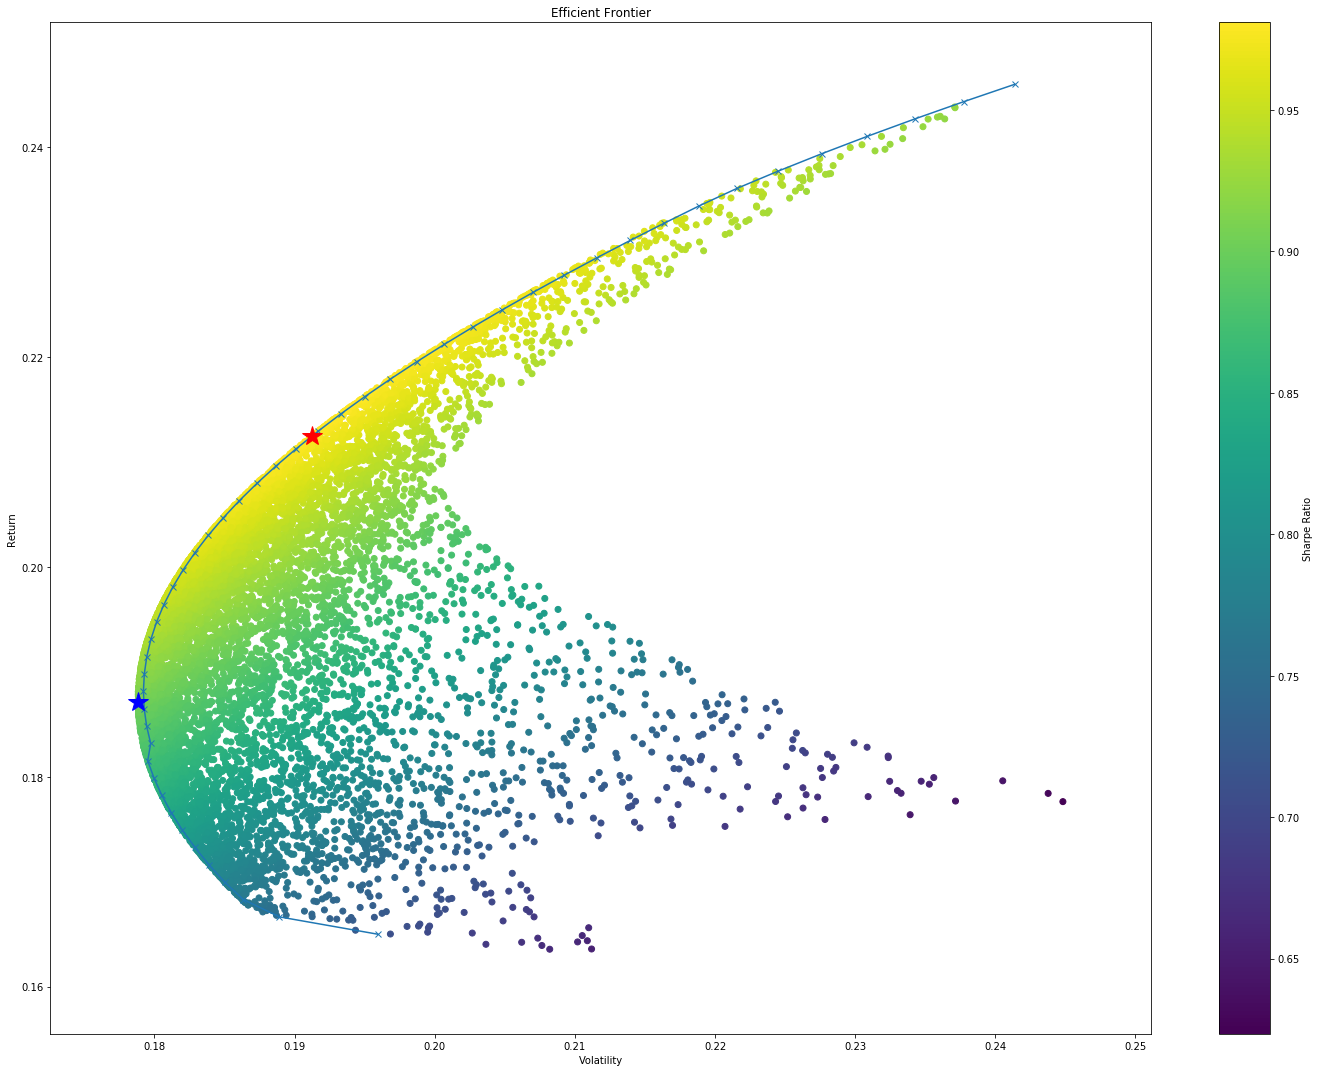

In [6]:
plt.figure(figsize=(20,15))
plt.scatter(monte_sim[1,:], monte_sim[0,:], c=monte_sim[2,:], marker='o')
plt.plot([p['fun']*np.sqrt(days_in_year) for p in efficient_portfolios], ((1+target_returns)**days_in_year)-1,marker='x')
plt.plot(max_sharpe_vol_annual, max_sharpe_ret_annual, 'r*', markersize=20.0)
plt.plot(min_vol_vol_annual, min_vol_ret_annual, 'b*', markersize=20.0)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.tight_layout()
plt.show()